In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk("../input/art-portraits/Portraits/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
np.random.seed(42)

../input/art-portraits/Portraits/Portraits/6b2168a48aa9562b90047eb8e86cd5fac.jpg
../input/art-portraits/Portraits/Portraits/c838d69ae53df58e6fad10a2913009dac.jpg
../input/art-portraits/Portraits/Portraits/f061edfc3bdea3a8964735b73f9b80c5c.jpg
../input/art-portraits/Portraits/Portraits/bbba4b7d701c9e1ea6c871e128fd3b2dc.jpg
../input/art-portraits/Portraits/Portraits/c9e39457dea5768250c0b7962eac9d53c.jpg
../input/art-portraits/Portraits/Portraits/be55c22476abcf322a703984b3907bebc.jpg
../input/art-portraits/Portraits/Portraits/bd1e66bf095624c52c46cc64759f0644c.jpg
../input/art-portraits/Portraits/Portraits/0b0323f784a9eee47a38b05e0c6f0a56c.jpg
../input/art-portraits/Portraits/Portraits/e5413a909084b494322f0ff117b0b06cc.jpg
../input/art-portraits/Portraits/Portraits/fb03a80bebdd5e58d3c5049f4b6633f4c.jpg
../input/art-portraits/Portraits/Portraits/7ebc8d18ce140c2987d15d8d7a078c36c.jpg
../input/art-portraits/Portraits/Portraits/1a8b914e716beed65130930ab1dd9ff8c.jpg
../input/art-portraits/Portr

In [ ]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
sns.set(rc={"axes.facecolor":"#EDE9DE","figure.facecolor":"#D8CA7E"})

Importing dataset

In [ ]:
data_path = "../input/art-portraits/Portraits/"
batch_s = 64
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 4117 files belonging to 1 classes.


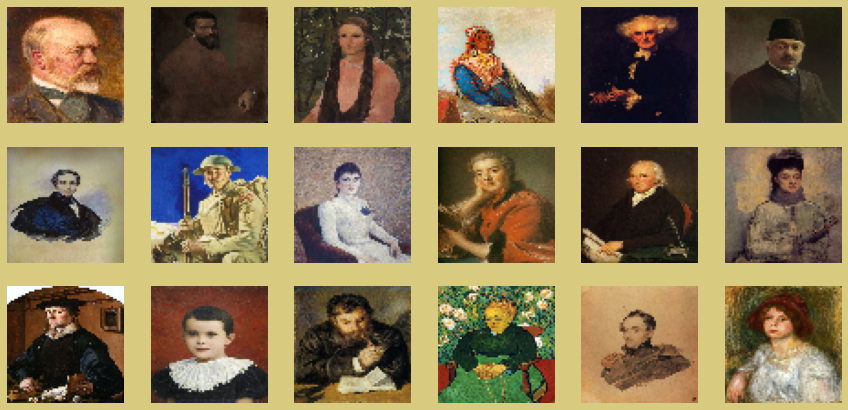

In [ ]:
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
Show_Img(data)

In [ ]:
data = data.map(lambda x: x / 255.0)
data

<MapDataset shapes: (None, 64, 64, 3), types: tf.float32>

Building a Generator

In [ ]:
latent_dim = 100
g_resolution=2

#Building a Generator
generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 256)         590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
activation (Activation)      (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0

(-0.5, 63.5, 63.5, -0.5)

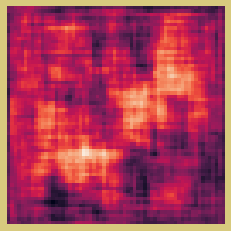

In [ ]:
seed = tf.random.normal([1, latent_dim])
Generated_Portrait = generator(seed, training=False)
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

Building a Discriminator

In [ ]:
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 17, 17, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 17, 17, 64)       

In [ ]:
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.4993935]], shape=(1, 1), dtype=float32)


In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator(seed)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))


        seed = tf.random.normal(shape=(batch_size, self.latent_dim))


        misleading_labels = tf.zeros((batch_size, 1))


        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

Training and Optimizing

In [ ]:
epochs = 200
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy()

model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

history = model.fit(data, epochs=epochs)

Epoch 1/200
65/65 [==============================] - 34s 421ms/step - d_loss: 0.6549 - g_loss: 0.7491
Epoch 2/200
65/65 [==============================] - 24s 316ms/step - d_loss: 0.6864 - g_loss: 0.7461
Epoch 3/200
65/65 [==============================] - 24s 324ms/step - d_loss: 0.6634 - g_loss: 0.8846
Epoch 4/200
65/65 [==============================] - 24s 322ms/step - d_loss: 0.6864 - g_loss: 0.7662
Epoch 5/200
65/65 [==============================] - 23s 315ms/step - d_loss: 0.6888 - g_loss: 0.8019
Epoch 6/200
65/65 [==============================] - 23s 314ms/step - d_loss: 0.6694 - g_loss: 0.7782
Epoch 7/200
65/65 [==============================] - 24s 317ms/step - d_loss: 0.6484 - g_loss: 0.8162
Epoch 8/200
65/65 [==============================] - 24s 320ms/step - d_loss: 0.6225 - g_loss: 0.8851
Epoch 9/200
65/65 [==============================] - 23s 312ms/step - d_loss: 0.6263 - g_loss: 0.9042
Epoch 10/200
65/65 [==============================] - 23s 314ms/step - d_loss: 0.6

Text(0.5, 1.0, 'Learning Curve')

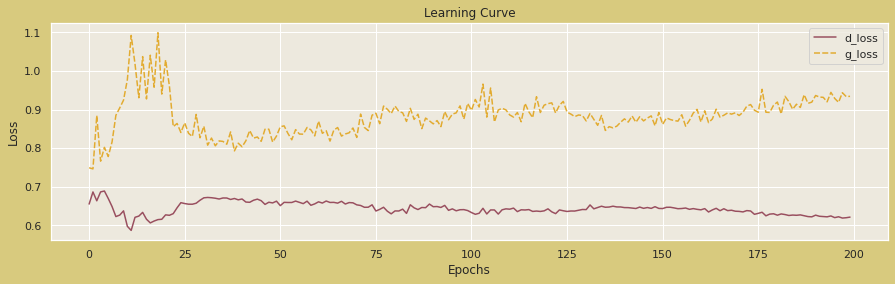

In [ ]:
pal=["#994F5F","#E2AB30"]
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
ax=sns.lineplot(data=history_df, palette= pal)
ax.set(xlabel ="Epochs")
ax.set(ylabel ="Loss")
ax.set_title("Learning Curve")

In [ ]:
num_img=18

def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("Potraits{:02d}.png".format(i))
    return

Images = Potrait_Generator()

Found 18 files belonging to 1 classes.


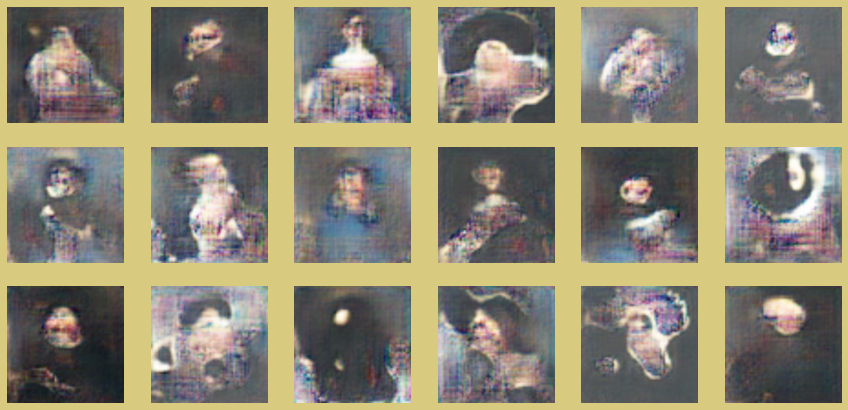

In [ ]:
Generated_path = "./"
Potraits_generated = tf.keras.preprocessing.image_dataset_from_directory(Generated_path, label_mode = None)
Show_Img(Potraits_generated)